In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

In [2]:
class RNN(tf.Module):
    
    def __init__(self, state_size, batch_size, **kwargs):
        super().__init__(**kwargs)

        # for calculating the next state
        self.w1 = tf.Variable(np.random.rand(state_size + 1, state_size), dtype=tf.float64)
        self.b1 = tf.Variable(np.random.rand(1), dtype=tf.float64)

        # for calculating output
        self.w2 = tf.Variable(np.random.rand(state_size, 1), dtype=tf.float64)
        self.b2 = tf.Variable(np.random.rand(1), dtype=tf.float64)

        self.states = tf.Variable(np.zeros((batch_size, state_size)), shape=(batch_size, state_size))

    # calculate output from current state
    # calcualte next state from current state + input
    # input shap: [batch_size, 1]
    def __call__(self, x):
        input_state_stacked = tf.concat([x, self.states], axis=1)
        output = tf.matmul(self.states, self.w2) + self.b2
        step = tf.matmul(input_state_stacked, self.w1)
        self.states = tf.tanh(step + self.b1)
        return output
        #return input_state_stacked

    def __str__(self):
        return " ".join([str(i) for i in self.state.numpy()])

* Input shape: [batch_size, sequence_lenght, n_features]
* I will assume n_features=1 to make my life easier

In [3]:
batch_size = 200
sequence_lenght = 10
#n_features = 1
#x = np.arange(batch_size * sequence_lenght).reshape((batch_size, sequence_lenght, 1))

x = np.random.choice([0,1], (batch_size, sequence_lenght, 1), p=[0.5,0.5])

In [4]:
rnn = RNN(5, batch_size)

In [5]:
X = tf.constant(x.copy(), dtype=tf.dtypes.float64)
output = rnn(X[:,1])

In [6]:
output[5:10, :]

<tf.Tensor: shape=(5, 1), dtype=float64, numpy=
array([[0.89249163],
       [0.89249163],
       [0.89249163],
       [0.89249163],
       [0.89249163]])>

In [7]:
output = rnn(X[:,1])

In [8]:
output[5:10, :]

<tf.Tensor: shape=(5, 1), dtype=float64, numpy=
array([[3.23290308],
       [3.23290308],
       [2.48206805],
       [3.23290308],
       [3.23290308]])>

In [9]:
rnn.states

<tf.Tensor: shape=(200, 5), dtype=float64, numpy=
array([[0.9961431 , 0.99666439, 0.99704637, 0.99412662, 0.99842187],
       [0.93379704, 0.96572808, 0.95372897, 0.95911013, 0.98011729],
       [0.9961431 , 0.99666439, 0.99704637, 0.99412662, 0.99842187],
       [0.93379704, 0.96572808, 0.95372897, 0.95911013, 0.98011729],
       [0.93379704, 0.96572808, 0.95372897, 0.95911013, 0.98011729],
       [0.9961431 , 0.99666439, 0.99704637, 0.99412662, 0.99842187],
       [0.9961431 , 0.99666439, 0.99704637, 0.99412662, 0.99842187],
       [0.93379704, 0.96572808, 0.95372897, 0.95911013, 0.98011729],
       [0.9961431 , 0.99666439, 0.99704637, 0.99412662, 0.99842187],
       [0.9961431 , 0.99666439, 0.99704637, 0.99412662, 0.99842187],
       [0.9961431 , 0.99666439, 0.99704637, 0.99412662, 0.99842187],
       [0.9961431 , 0.99666439, 0.99704637, 0.99412662, 0.99842187],
       [0.9961431 , 0.99666439, 0.99704637, 0.99412662, 0.99842187],
       [0.93379704, 0.96572808, 0.95372897, 0.9591101

## Testing

I will generate binary sequences and train a model to create an offset output

In [10]:
# x: batch of sequences (batch_size, sequence length)
def train(model, x, y_actual, learning_rate):

    y_preds = []

    with tf.GradientTape() as tape:
        for point in range(x.shape[1]):
            y_preds.append(model(x[:, point, None]))

        y_pred = tf.concat(y_preds, axis = 1)

        current_loss = tf.reduce_mean(tf.square(y_pred - y_actual))

        d_w1, d_b1, d_w2, d_b2 = tape.gradient(current_loss, [model.w1, model.b1, model.w2, model.b2])

        model.w1.assign_sub(learning_rate * d_w1)
        model.b1.assign_sub(learning_rate * d_b1)
        model.w2.assign_sub(learning_rate * d_w2)
        model.b2.assign_sub(learning_rate * d_b2)

    return current_loss

In [11]:
# Define a training loop
def training_loop(model, x, y_actual, epochs, learning_rate, print_every = 1):

    for epoch in range(epochs):

        for batch in range(x.shape[0]):
            # Update the model with the single giant batch
            current_loss = train(model, x[batch, :, :], y_actual[batch, :, :], learning_rate)

            #current_loss = tf.reduce_mean(tf.square(y_actual, model(x))

        if epoch%print_every == 0 or epoch == epochs-1:
            print("Epoch %2d: loss=%2.5f" % (epoch, current_loss))

In [12]:
SEQUENCE_LENGHT = 10
BATCH_SIZE = 50
N_BATCHES = 1
N_EPOCH = 20

X = np.random.choice([0,1], (N_BATCHES, BATCH_SIZE, SEQUENCE_LENGHT), p=[0.5,0.5])
X = tf.constant(X, dtype = tf.dtypes.float64)

SHIFT_BY = 3
y = np.roll(X, SHIFT_BY, axis=2)
y[:, :, :SHIFT_BY] = 0
y = tf.constant(y, dtype = tf.dtypes.float64)

rnn = RNN(5, BATCH_SIZE)

In [13]:
rnn.w2

<tf.Variable 'Variable:0' shape=(5, 1) dtype=float64, numpy=
array([[0.47414275],
       [0.70847068],
       [0.26819504],
       [0.05449054],
       [0.81071958]])>

In [14]:
training_loop(rnn, X, y, N_EPOCH, 0.02, 1)

Epoch  0: loss=4.77496
Epoch  1: loss=3.79856
Epoch  2: loss=2.29946
Epoch  3: loss=1.42941
Epoch  4: loss=0.92439
Epoch  5: loss=0.63125
Epoch  6: loss=0.46110
Epoch  7: loss=0.36233
Epoch  8: loss=0.30500
Epoch  9: loss=0.27172
Epoch 10: loss=0.25241
Epoch 11: loss=0.24119
Epoch 12: loss=0.23468
Epoch 13: loss=0.23091
Epoch 14: loss=0.22871
Epoch 15: loss=0.22744
Epoch 16: loss=0.22670
Epoch 17: loss=0.22627
Epoch 18: loss=0.22602
Epoch 19: loss=0.22588


In [19]:
def plot_data(x, y, batch_index, sequence_index, model = None):
    # plot x to 0.25,
    # plot y to 0.5
    # plot predictions to 1

    plt.plot(x[batch_index, sequence_index, :], label='input')
    plt.plot(y[batch_index, sequence_index, :], label='actual output')

    if model != None:
        preds = []
        for index in range(x.shape[2]):
            input = x[batch_index, :, index, None]
            preds.append(model(input)[sequence_index])
        plt.plot(preds, label='predicted output')

    plt.legend()
    plt.show()

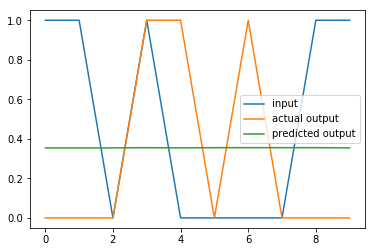

In [20]:
plot_data(X, y, 0, 10, rnn)